<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W3D3_OptimalControl/W3D3_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Optimal Control for Discrete States
**Week 3, Day 3: Optimal Control**

**By Neuromatch Academy**

__Content creators:__ Zhengwei Wu, Shreya Saxena, Xaq Pitkow

__Content reviewers:__ Karolina Stosio, Roozbeh Farhoodi, Saeed Salehi, Ella Batty, Spiros Chavlis, Matt Krause, and Michael Waskom

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

In this tutorial, we will implement a binary control task: a Partially Observable Markov Decision Process (POMDP) that describes fishing. The agent (you) seeks reward from two fishing sites without directly observing where the school of fish is (a group of fish is called a school!). This makes the world a Hidden Markov Model. Based on when and where you catch fish, you keep updating your belief about the fish location, _i.e._ the posterior of the fish given past observations. You should control your position to get the most fish while minimizing the cost of switching sides.

You've already learned about stochastic dynamics, latent states, and measurements. Now we introduce you to the new concepts of **control, utility, and policy**.

In [ ]:
# @title Tutorial slides

# @markdown These are the slides for all videos in this tutorial.
from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/8j5rs/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
## Setup  



In [1]:
# Imports

import numpy as np
import scipy
from scipy.linalg import inv
from math import isclose
import matplotlib.pyplot as plt

In [2]:
#@title Figure Settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import ipywidgets as widgets
from ipywidgets import interact, fixed, HBox, Layout, VBox, interactive, Label
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
# @title Plotting Functions


def plot_fish(fish_state, ax=None):
  """
  Plot the fish dynamics
  """
  T = len(fish_state)

  showlen = min(T, 200)
  startT = 0

  endT = startT + showlen
  showT = range(startT, endT)
  time_range = np.linspace(0, showlen - 1)

  if not ax:
    fig, ax = plt.subplots(1, 1, figsize=(12, 2.5))
  ax.plot(- fish_state[showT], color='dodgerblue', markersize=10, linewidth=3.0)
  ax.set_xlabel('time', fontsize=18)
  ax.set_ylabel('Fish state', rotation=360, fontsize=18)
  ax.yaxis.set_label_coords(-0.1, 0.25)
  ax.set_xticks([0, showlen, showlen])
  ax.tick_params(axis='both', which='major', labelsize=18)
  ax.set_xlim([0, showlen])
  ax.set_ylim([-1.1, 1.1])
  ax.set_yticks([-1, 1])
  ax.tick_params(axis='both', which='major', labelsize=18)
  labels = [item.get_text() for item in ax.get_yticklabels()]
  labels[0] = 'Right'
  labels[1] = 'Left'
  ax.set_yticklabels(labels)


def plot_measurement(measurement, ax=None):
  """
  Plot the measurements
  """
  T = len(measurement)

  showlen = min(T, 200)
  startT = 0
  endT = startT + showlen
  showT = range(startT, endT)
  time_range = np.linspace(0, showlen - 1)

  if not ax:
    fig, ax = plt.subplots(1, 1, figsize=(12, 2.5))
  ax.plot(measurement[showT], 'r*', markersize=5)
  ax.set_xlabel('time', fontsize=18)
  ax.set_ylabel('Measurement', rotation=360, fontsize=18)
  ax.yaxis.set_label_coords(-0.2, 0.4)
  ax.set_xticks([0, showlen, showlen])
  ax.tick_params(axis='both', which='major', labelsize=18)
  ax.set_xlim([0, showlen])
  ax.set_ylim([-.1, 1.1])
  ax.set_yticks([0, 1])
  ax.set_yticklabels(['no fish', 'caught fish'])


def plot_act_loc(loc, act, ax_loc=None):
  """
  Plot the action and location of 200 time points
  """
  T = len(act)

  showlen = min(T, 200)
  startT = 0

  endT = startT + showlen
  showT = range(startT, endT)
  time_range = np.linspace(0, showlen - 1)

  if not ax_loc:
    fig, ax_loc = plt.subplots(1, 1, figsize=(12, 2.5))

  act_int = (act == "switch").astype(int)
  ax_loc.plot(-loc[showT], 'g.-', markersize=8, linewidth=5)
  ax_loc.plot((act_int[showT] * 4 - 3) * .5, 'rv', markersize=12,
              label='switch')
  ax_loc.set_xlabel('time', fontsize=18)
  ax_loc.set_ylabel('Your state', rotation=360, fontsize=18)

  ax_loc.legend(loc="upper right", fontsize=12)
  ax_loc.set_xlim([0, showlen])
  ax_loc.set_ylim([-1.1, 1.1])
  ax_loc.set_yticks([-1, 1])
  ax_loc.set_xticks([0, showlen, showlen])
  ax_loc.tick_params(axis='both', which='major', labelsize=18)
  labels = [item.get_text() for item in ax_loc.get_yticklabels()]
  labels[1] = 'Left'
  labels[0] = 'Right'
  ax_loc.set_yticklabels(labels)


def plot_belief(belief, ax1=None, choose_policy=None):
  """
  Plot the belief dynamics of 200 time points
  """

  T = belief.shape[1]

  showlen = min(T, 200)
  startT = 0

  endT = startT + showlen
  showT = range(startT, endT)
  time_range = np.linspace(0, showlen - 1)

  if not ax1:
      fig, ax1 = plt.subplots(1, 1, figsize=(12, 2.5))

  ax1.plot(belief[0, showT], color='dodgerblue', markersize=10, linewidth=3.0)
  ax1.yaxis.set_label_coords(-0.1, 0.25)
  ax1.set_xlabel('time', rotation=360, fontsize=18)
  ax1.set_ylabel('Belief on \n left', rotation=360, fontsize=18)
  ax1.tick_params(axis='both', which='major', labelsize=18)
  ax1.set_xlim([0, showlen])
  ax1.set_yticks([0, 1])
  ax1.set_ylim([0, 1.1])
  ax1.set_xticks([0, showlen, showlen])

  if choose_policy == "threshold":
    ax2 = ax1.twinx()
    ax2.plot(time_range, threshold * np.ones(time_range.shape), 'r--')
    ax2.plot(time_range, (1 - threshold) * np.ones(time_range.shape), 'c--')
    ax2.set_yticks([threshold, 1 - threshold])
    ax2.set_ylim([0, 1.1])
    ax2.tick_params(axis='both', which='major', labelsize=18)
    labels = [item.get_text() for item in ax2.get_yticklabels()]
    labels[0] = 'threshold to switch \n from left to right'
    labels[-1] = 'threshold to switch \n from right to left'
    ax2.set_yticklabels(labels)


def plot_dynamics(belief, loc, act, meas, fish_state, choose_policy):
  """
  Plot the dynamics of 200 time points
  """
  if choose_policy == 'threshold':
    fig, [ax0, ax_loc, ax1, ax_bel] = plt.subplots(4, 1, figsize=(12, 9))
    plot_fish(fish_state, ax=ax0)
    plot_belief(belief, ax1=ax_bel)
    plot_measurement(meas, ax=ax1)
    plot_act_loc(loc, act, ax_loc=ax_loc)
  else:
    fig, [ax0, ax1, ax_bel] = plt.subplots(3, 1, figsize=(12, 7))
    plot_fish(fish_state, ax=ax0)
    plot_belief(belief, ax1=ax_bel)
    plot_measurement(meas, ax=ax1)

  plt.tight_layout()
  plt.show()


def belief_histogram(belief, bins=100):
  """
  Plot the histogram of belief states
  """
  fig, ax = plt.subplots(1, 1, figsize=(8, 6))
  ax.hist(belief, bins)
  ax.set_xlabel('belief', fontsize=18)
  ax.set_ylabel('count', fontsize=18)
  plt.show()


def plot_value_threshold(cost_sw=0.5, T=10000, p_stay=.95,
                         high_rew_p=.4, low_rew_p=.1, step=.05):
  """
  Helper function to plot the value function and threshold
  """
  params = [T, p_stay, high_rew_p, low_rew_p, _]

  threshold_array, value_array = value_threshold(params, cost_sw, step)
  yrange = np.max(value_array) - np.min(value_array)

  fig_, ax = plt.subplots(1, 1, figsize=(8, 6))
  ax.plot(threshold_array, value_array, 'b')
  ax.set_ylim([np.min(value_array) - yrange * .1, np.max(value_array) + yrange * .1])
  ax.set_title(f'threshold vs value with switching cost c = {cost_sw:.2f}',
               fontsize=20)
  ax.set_xlabel('threshold', fontsize=16)
  ax.set_ylabel('value', fontsize=16)
  plt.show()

In [4]:
# @title Helper Functions

binomial = np.random.binomial


class ExcerciseError(AssertionError):
  pass


def test_policy_threshold():
  well_done = True
  for loc in [-1, 1]:
    threshold = 0.4
    belief = np.array([.2, .3])
    if policy_threshold(threshold, belief, loc) != "switch":
      raise ExcerciseError("'policy_threshold' function is not correctly implemented!")
  for loc in [1, -1]:
    threshold = 0.6
    belief = np.array([.7, .8])
    if policy_threshold(threshold, belief, loc) != "stay":
      raise ExcerciseError("'policy_threshold' function is not correctly implemented!")
  print("Well Done!")


def test_value_function():
  measurement = np.array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1])
  act = np.array(["switch", "stay", "switch", "stay", "stay",
                  "stay", "switch", "switch", "stay", "stay"])
  cost_sw = .5
  if not isclose(value_function(measurement, act, cost_sw), .1):
    raise ExcerciseError("'value_function' function is not correctly implemented!")
  print("Well Done!")

---
# Section 1: Dynamics of Fishing

In [5]:
# @title Video 1: Gone fishing
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1FL411p7o5", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="3oIwUFpolVA", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

There are two locations for the fish and you (Left and Right). If you're on the same side as the fish, you'll catch more, with probabilty $q_{\rm high}$ per discrete time step. Otherwise you may still catch fish with probability $q_{\rm low}$. One fish is worth 1 "point".

The fish location $s^{\rm fish}$ is latent. The only information you get about the fish location is when you catch one. Secretly at each time step, the fish may switch sides with a certain probability $p_{\rm sw} = 1 - p_{\rm stay}$.


You are in control of your own location. You may stay on your current side with no cost, or switch to the other side and incur an action cost $C$ (again, in units of fish).

You select controls or actions by following a **policy**. This defines what to do in any situation. Here the situation is specified by your location and your belief $b_t$ about the fish location. For optimal control we assume that this belief is the posterior probability over the current fish location, given all the past measurements. We only need one number for this, since the fish are either on the left or the right. So we write 

$$b_t = p(s^{\rm fish}_t = {\rm Right}\ |\ m_{0:t}, a_{0:t-1})$$

where $m$ are the measurements, and $a$ are the controls or actions (stay or switch).

Ultimately we will parameterize the policy by a simple threshold on beliefs. (This happens to be optimal if you pick the right threshold!) When your belief that fish are on your current side falls below a threshold $\theta$, you switch to the other side.

Your **overall goals** in this tutorial are:
1. Measure when fish are caught, first if the school of fish doesn't move.
2. For moving fish, plot their dynamics and your belief about it based on your measurements.
3. Compute the value for a given control policy.
4. Find the optimal policy for controlling your position.

## Interactive Demo 1: Examining fish dynamics

In this demo, we will look at the dynamics of the fish moving from side to side. We will use the helper class `binaryHMM`, implemented in the next cell. Please take some time to study this class and its methods. You will then see a demo where you can change the probability of switching states and examing the resulting dynamics of the fish.


In [6]:
class binaryHMM():

  def __init__(self, params, fish_initial=-1, loc_initial=-1):
    self.params = params
    self.fish_initial = fish_initial
    self.loc_initial = loc_initial

  def fish_state_telegraph(self, fish_past, p_stay):
    """
    fish state update according to telegraph process

    Args:
      fish_past (int): the fish location (-1 for left side, 1 for right side)
      p_stay : the probability that the state of a certain site stays the same

    Returns:
      fish_new (int): updated fish location
    """
    # we use logical operation XOR (denoted by ^ in python)
    # if first bit is 0 (stay), the second bit (which side) stays the same
    # if first bit is 1 (move), the second bit (which side) flips 
    
    fish_new = (1 - binomial(1, p_stay)) ^ ((fish_past + 1) // 2)
    
    fish_new = fish_new * 2 - 1

    return fish_new


  def fish_dynamics(self):
    """
    fish state dynamics according to telegraph process

    Returns:
      fish_state (numpy array of int)
    """
    T, p_stay, _, _, _ = self.params
    fish_state = np.zeros(T, int)  # -1: left side ; 1: right side

    # initialization
    fish_state[0] = self.fish_initial

    for t in range(1, T):
        fish_state[t] = self.fish_state_telegraph(fish_state[t - 1], p_stay)

    return fish_state

  def generate_process_lazy(self):
    """
    fish dynamics and measurements if you always stay in the intial location
    without changing sides

    Returns:
      fish_state (numpy array of int): locations of the fish
      loc (numpy array of int): left or right site, -1 for left, and 1 for right
      measurement (numpy array of binary): whether a reward is obtained
    """

    T, _, high_rew_p, low_rew_p, _ = self.params
    rew_p_vector = np.array([low_rew_p, high_rew_p])

    fish_state = self.fish_dynamics()
    loc  = np.zeros(T, int)            # -1: left side, 1: right side
    measurement = np.zeros(T, int)     # 0: no food, 1: get food

    for t in range(0, T):
      loc[t] = self.loc_initial
      # new measurement
      measurement[t] = binomial(1, rew_p_vector[(fish_state[t] == loc[t]) * 1])

    return fish_state, loc, measurement

In [7]:
def update_ex_1(p_stay=.95, high_rew_p=.4, low_rew_p=.1, T=200):
  """
    p_stay: probability fish stay
    high_rew_p: p(catch fish) when you're on their side
    low_rew_p : p(catch fish) when you're on other side
  """

  params = [T, p_stay, high_rew_p, low_rew_p, _]

  #### initial condition for fish [fish_initial] and you [loc_initial] ####
  binaryHMM_test = binaryHMM(params, fish_initial=-1, loc_initial=-1)

  fish_state = binaryHMM_test.fish_dynamics()
  plot_fish(fish_state)

In [8]:
# @markdown Make sure you execute this cell to enable the widget!


widget=interactive(update_ex_1, {'manual': True},
                high_rew_p=fixed(.4),
                low_rew_p=fixed(.1),
                p_stay=(.5, 1., .001),
                T=fixed(200))

widget.children[-2].description='Run Simulation'
widget.children[-2].style.button_color='lightgreen'
controls = HBox(widget.children[:-1], layout=Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]))

---
# Section 2: Catching fish

In [9]:
# @title Video 2: Catch some fish
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1kD4y1m7Lo", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="1-Wionllt9U", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Interactive Demo 2: Catching fish

Now set $p_{\rm stay} = 1$ so that the state of the two sites are fixed, and we can directly see the chances of catching fish on each side. The variable `fish_initial` indicates the initial side of the fish, and `loc_initial` indicates your initial location. They each take value $-1$ for left and $1$ for right.

**Instructions:**
1. set the two locations (`fish_initial` and `loc_initial`) to be the _same_, and measure when you catch fish.
2. set the two locations (`fish_initial` and `loc_initial`) to be the _different_, and measure when you catch fish.
3. visually compare the measurements from 1 and 2.
4. Finally, you can also play around with `high_rew_p` (high reward probability) and `low_rew_p` (low reward probability) sliders.

In [14]:
def update_ex_2(p_stay=1., high_rew_p=.6, low_rew_p=.05, T=100):
  """
    p_stay: probability fish stay
    high_rew_p: p(catch fish) when you're on their side (conditional probability: p(catch fish | same side))
    low_rew_p : p(catch fish) when you're on other side (conditional probability: p(catch fish | diff side))
  """
  params = [T, p_stay, high_rew_p, low_rew_p, _]

  #### initial condition for fish [fish_initial] and you [loc_initial] ####
  binaryHMM_test = binaryHMM(params, fish_initial=-1, loc_initial=-1)

  fish_state, loc, measurement = binaryHMM_test.generate_process_lazy()
  plot_measurement(measurement)

In [13]:
#@markdown Make sure you execute this cell to enable the widget!

widget=interactive(update_ex_2, {'manual': True},
                high_rew_p=(.0, 1., .001),
                low_rew_p=(.0, 1., .001),
                p_stay=fixed(1.),
                T=fixed(100))

widget.children[-2].description='Run Simulation'
widget.children[-2].style.button_color='lightgreen'
controls = HBox(widget.children[:-1], layout=Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]))

---
# Section 3: Belief dynamics and belief distributions

In [15]:
# @title Video 3: Where are the fish?
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV19t4y1Q7VH", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="wCzVnnd4bmg", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

We have provided a class for the binary task, with the agent always staying at one side following a lazy policy function `def policy_lazy(belief, loc)` that we provided. Now in this exercise, you will extend the module to generate the real dynamics, including beliefs and a moving agent. With the generated data, we will see how beliefs change over time, and how often different beliefs happen.

For convenience, your belief at time *t* is actually a 2-dimensional vector. The first element is the belief that the fish are on the left, and the second element is the belief the fish are on the right. At every time, these elements sum to $1$.

We will first check the dynamics with lazy policy, and then explore the case with a threshold-based policy.


Evaluate the cells below to setup the lazy policy.


In [16]:
class binaryHMM_belief(binaryHMM):

  def __init__(self, params, fish_initial = -1, loc_initial = -1,
                choose_policy = 'threshold'):
    binaryHMM.__init__(self, params, fish_initial, loc_initial)
    self.choose_policy = choose_policy

  def generate_process(self):
    """
    fish dynamics and measurements based on the choosen policy

    Returns:
      belief (numpy array of float): belief on the states of the two sites
      act (numpy array of string): actions over time
      loc (numpy array of int): left or right site
      measurement (numpy array of binary): whether a reward is obtained
      fish_state (numpy array of int): fish locations
    """

    T, p_stay, high_rew_p, low_rew_p, threshold = self.params
    fish_state = self.fish_dynamics()     # -1: left side; 1: right side
    loc = np.zeros(T, int)                # -1: left side, 1: right side
    measurement = np.zeros(T, int)        # 0: no food, 1: get food
    act = np.empty(T, dtype='object')     # "stay", or "switch"
    belief = np.zeros((2, T), float)      # the probability that the fish is on the left (1st element)
                                          # or on the right (2nd element),
                                          # the beliefs on the two boxes sum up to be 1

    rew_prob = np.array([low_rew_p, high_rew_p])

    # initialization
    loc[0] = -1
    measurement[0] = 0
    belief_0 = np.random.random(1)[0]
    belief[:, 0] = np.array([belief_0, 1 - belief_0])
    act[0] = self.policy(threshold, belief[:, 0], loc[0])

    for t in range(1, T):
      if act[t - 1] == "stay":
        loc[t] = loc[t - 1]
      else:
        loc[t] = - loc[t - 1]

      # new measurement
      measurement[t] = binomial(1, rew_prob[(fish_state[t] == loc[t]) * 1])
      belief[0, t] = self.belief_update(belief[0, t - 1] , loc[t],
                                        measurement[t], p_stay,
                                        high_rew_p, low_rew_p)
      belief[1, t] = 1 - belief[0, t]

      act[t] = self.policy(threshold, belief[:, t], loc[t])

    return belief, loc, act, measurement, fish_state

  def policy(self, threshold, belief, loc):
    """
    chooses policy based on whether it is lazy policy
        or a threshold-based policy

    Args:
      threshold (float): the threshold of belief on the current site,
          when the belief is lower than the threshold, switch side
      belief (numpy array of float): the belief on the two sites
      loc (int) : the location of the agent

    Returns:
      act (string): "stay" or "switch"
    """
    if self.choose_policy == "threshold":
      act = policy_threshold(threshold, belief, loc)
    if self.choose_policy == "lazy":
      act = policy_lazy(belief, loc)

    return act

  def belief_update(self, belief_past, loc, measurement, p_stay,
                    high_rew_p, low_rew_p):
    """
    using PAST belief on the LEFT box, CURRENT location and
        and measurement to update belief
    """
    rew_prob_matrix = np.array([[1 - high_rew_p, high_rew_p],
                                [1 - low_rew_p, low_rew_p]])

    # update belief posterior, p(s[t] | measurement(0-t), act(0-t-1))
    belief_0 = (belief_past * p_stay  + (1 - belief_past) * (1 - p_stay)) *\
                            rew_prob_matrix[(loc + 1) // 2, measurement]
    belief_1 = ((1 - belief_past) * p_stay + belief_past * (1 - p_stay)) *\
                            rew_prob_matrix[1-(loc + 1) // 2, measurement]

    belief_0 = belief_0 / (belief_0 + belief_1)

    return belief_0

In [17]:
def policy_lazy(belief, loc):
  """
  This function is a lazy policy where stay is also taken
  """
  act = "stay"

  return act

## Interactive Demo 3: Task dynamics following a **lazy** policy

The parameter for policy `choose_policy` can be either "*lazy*" or "*threshold*". In the following example, use the lazy policy.

**Instructions:**
* With the class defined above, we have created an object of `binaryHMM_belief` given parameters of the dynamics, *params*, and a parameter for policy.
* Run the dynamics and explain the time series of the beliefs you see.


In [18]:
def update_ex_3(p_stay=.98, threshold=.2, high_rew_p=.4, low_rew_p=.1, T=200):
  """
    p_stay: probability fish stay
    high_rew_p: p(catch fish) when you're on their side
    low_rew_p : p(catch fish) when you're on other side
    threshold: threshold of belief below which switching is taken
  """

  params = [T, p_stay, high_rew_p, low_rew_p, threshold]

  #### initial condition for fish [fish_initial] and you [loc_initial] ####
  binaryHMM_test = binaryHMM_belief(params, choose_policy="lazy",
                                    fish_initial=-1, loc_initial=-1)

  belief, loc, act, measurement, fish_state = binaryHMM_test.generate_process()
  plot_dynamics(belief, loc, act, measurement, fish_state,
                binaryHMM_test.choose_policy)

In [19]:
#@markdown Make sure you execute this cell to enable the widget!

widget=interactive(update_ex_3, {'manual': True},
                high_rew_p=(.0, 1., .001),
                low_rew_p=(.0, 1., .001),
                p_stay=(.5, 1., .001),
                T=fixed(200),
                threshold=fixed(.2))

widget.children[-2].description='Run Simulation'
widget.children[-2].style.button_color='lightgreen'
controls = HBox(widget.children[:-1], layout=Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]))

---
# Section 4: Implementing threshold policy

In [20]:
# @title Video 4: How should you act?
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1ri4y137cj", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="G3fNz23IDUg", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Coding Exercise 4: dynamics following a **threshold-based** policy.

**Instructions:**

* You need to code a new policy `def policy_threshold(threshold, belief, loc)`. The policy takes three inputs: your belief about the fish state, your location ("Left" or "Right"), and a belief _threshold_: when your belief that you are on the same side as the fish drops below this threshold, you choose to switch; otherwise you stay.

* You should return an action for each time *t*, which takes the value of "stay" or "switch".

* After you complete the code for the policy based on threshold, create an object of `binaryHMM_belief` and set the policy parameter to be `choose_policy = threshold`.
* We have provided an example of the parameters. You should play with the parameters to see the various dynamics.

In [22]:
def policy_threshold(threshold, belief, loc):
  """
  chooses whether to switch side based on whether the belief
      on the current site drops below the threshold

  Args:
    threshold (float): the threshold of belief on the current site,
                        when the belief is lower than the threshold, switch side
    belief (numpy array of float, 2-dimensional): the belief on the
                                                  two sites at a certain time
    loc (int) : the location of the agent at a certain time
                -1 for left side, 1 for right side

  Returns:
    act (string): "stay" or "switch"
  """
  ############################################################################
  ## Insert code to:
  ## generate actions (Stay or Switch) for current belief and location
  ##
  ## Belief is a 2d vector: first element = Prob(fish on Left | measurements)
  ##                       second element = Prob(fish on Right  | measurements)
  ## Returns "switch" if Belief that fish are in your current location < threshold
  ##         "stay" otherwise
  ##
  ## Hint: use loc value to determine which row of belief you need to use
  ##       see the docstring for more information about loc
  ##
  ## complete the function and remove
  #raise NotImplementedError("Student exercise: Please complete <act>")
  ############################################################################
  # Write the if statement
  if belief[(loc + 1) // 2] <= threshold:
    # action below threshold
    act = 'switch'
  else:
    # action above threshold
    act = 'stay'

  return act


# Test your function
test_policy_threshold()

Well Done!


In [ ]:
# to_remove solution
def policy_threshold(threshold, belief, loc):
  """
  chooses whether to switch side based on whether the belief
      on the current site drops below the threshold

  Args:
    threshold (float): the threshold of belief on the current site,
                        when the belief is lower than the threshold, switch side
    belief (numpy array of float, 2-dimensional): the belief on the
                                                  two sites at a certain time
    loc (int) : the location of the agent at a certain time
                -1 for left side, 1 for right side

  Returns:
    act (string): "stay" or "switch"
  """
  # Write the if statement
  if belief[(loc + 1) // 2] <= threshold:
    # action below threshold
    act = "switch"
  else:
    # action above threshold
    act = "stay"

  return act


# Test your function
test_policy_threshold()

## Interactive Demo 4: Dynamics with different thresholds

In [23]:
def update_ex_4(p_stay=.98, threshold=.2, high_rew_p=.4, low_rew_p=.1, T=200):
  """
    p_stay: probability fish stay
    high_rew_p: p(catch fish) when you're on their side
    low_rew_p : p(catch fish) when you're on other side
    threshold: threshold of belief below which switching is taken
  """
  params = [T, p_stay, high_rew_p, low_rew_p, threshold]

  #### initial condition for fish [fish_initial] and you [loc_initial] ####
  binaryHMM_test = binaryHMM_belief(params, fish_initial=-1, loc_initial=-1,
                                    choose_policy="threshold")

  belief, loc, act, measurement, fish_state = binaryHMM_test.generate_process()
  plot_dynamics(belief, loc, act, measurement,
                fish_state, binaryHMM_test.choose_policy)

In [24]:
#@markdown Make sure you execute this cell to enable the widget!

widget=interactive(update_ex_4, {'manual': True},
                high_rew_p=fixed(.4),
                low_rew_p=fixed(.1),
                p_stay=fixed(.95),
                T=fixed(200),
                threshold=(.0, 1., .001))

widget.children[-2].description='Run Simulation'
widget.children[-2].style.button_color='lightgreen'
controls = HBox(widget.children[:-1], layout=Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]))

---
# Section 5: Implementing a value function

In [25]:
# @title Video 5: Evaluate policy
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1TD4y1D7K3", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="aJhffROC74w", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Coding Exercise 5: Implementing a value function

Now we have generated behavior for a policy parameterized by a threshold. While it seems clear that this is at least better than being lazy, we want to know how good it is. For that, we will calculate a _value function_. We will use this value to compare different policies, and maximize the amount of fish we catch while minimizing our effort. 

Specifically, here the value is total expected utility per unit time.

$$V(\theta) = \frac{1}{T}\left(\sum_t U_s(s_t) + U_a(a_t)\right)$$ 

where $U_s(s_t)$ is the instantaneous utility (reward) from the site, and $U_a(a_t)$ is the utility (negative cost) for the chosen action. Here, the action cost is 0 if you stay, and `cost_sw` if you switch. 

We could take this average mathematically over the probabilities of rewards and actions. More simply, we get the same answer by simply averaging the _actual_ rewards and costs over a long time, so that's what you should do.


**Instructions**
* Fill in the function `value_function(measurement, act, cost_sw)` given a sequence of measurements, actions, and the cost of switching.
* Visually find the threshold that yields the highest total value. We have provided code for plotting value versus threshold. The threshold $\theta^*$ with the highest value gives the optimal policy for controlling where you should fish.

In [38]:
def value_function(measurement, act, cost_sw):
  """
  value function

  Args:
    act (numpy array of string): length T with each element
                                  taking value "stay" or "switch"
    cost_sw (float): the cost of switching side
    measurement (numpy array of binary): whether a reward is obtained

  Returns:
    value (float): expected utility per unit time
  """
  act_int = (act == "switch").astype(int)
  T = len(measurement)
  ############################################################################
  ## Insert your code here to:
  ##        compute the value function = rate of catching fish - costs
  ##
  ## complete the function and remove
  #raise NotImplementedError("Student exercise: Please complete <value>")
  ############################################################################
  # Calculate the value function
  value = (1 / T) * np.sum(measurement - cost_sw * act_int)
  #value = np.mean(measurement - cost_sw * act_int)

  return value


# Test your function
test_value_function()

Well Done!


In [35]:
# to_remove solution

def value_function(measurement, act, cost_sw):
  """
  value function

  Args:
    act (numpy array of string): length T with each element
                                  taking value "stay" or "switch"
    cost_sw (float): the cost of switching side
    measurement (numpy array of binary): whether a reward is obtained

  Returns:
    value (float): expected utility per unit time
  """
  act_int = (act == "switch").astype(int)
  T = len(measurement)
  # Calculate the value function
  value = np.sum(measurement - act_int * cost_sw) / T

  return value


# Test your function
test_value_function()

Well Done!


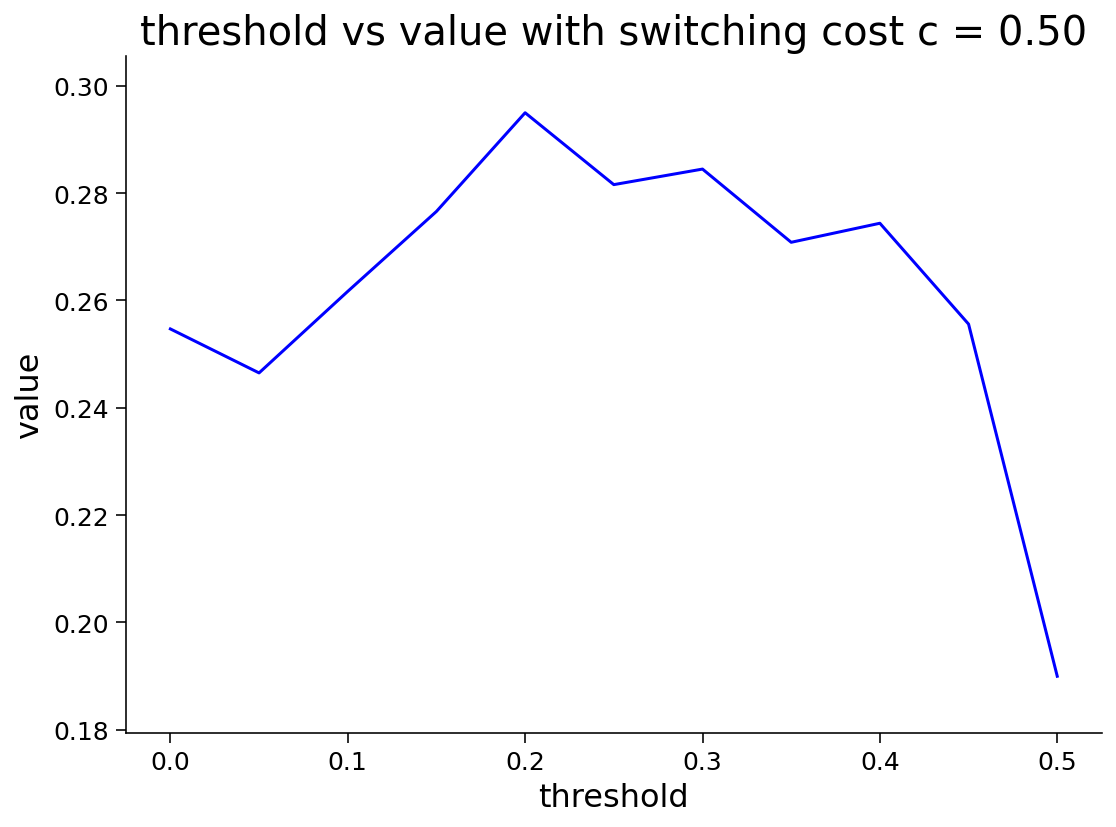

In [41]:
# Brute force search for optimal policy: loop over thresholds and compute value for each.
# This function is needed for the second exercise.


def value_threshold(params, cost_sw, step):
  threshold_array = np.arange(0, .5 + step, step)
  value_array = np.zeros(threshold_array.shape)

  T, p_stay, high_rew_p, low_rew_p, _ = params

  for i in range(len(threshold_array)):
    threshold = threshold_array[i]

    params = [T, p_stay, high_rew_p, low_rew_p, threshold]
    binaryHMM_test = binaryHMM_belief(params, choose_policy="threshold")
    belief, loc, act, measurement, fish_state = binaryHMM_test.generate_process()

    value_array[i] = value_function(measurement, act, cost_sw)

  return threshold_array, value_array


plot_value_threshold(cost_sw=0.5, p_stay=0.95, high_rew_p=0.4, low_rew_p=0.1, T=10000)

---
# Summary

In this tutorial, you have used the Hidden Markov Models you learned about yesterday to figure out where the fish are, and then you have acted (moved location) to catch the most fish. In particular, you have found an optimal policy to guide your actions.

---
# Bonus

---
## Bonus Section 1: Different task, different optimal policy

In [31]:
# @title Video 6: Sensitivity of optimal policy
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1QK4y1e7N9", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="wd8IVsKoEfA", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

### Bonus Interactive Demo 1

**Instructions:**
After plotting value versus threshold, adjust various task parameters using the sliders below, and observe how the optimal threshold moves with
* switching cost (`cost_sw`)
* fish dynamics (`p_switch`)
* probability of catching fish on each side, `low_rew_p` and `high_rew_p`

Can you explain why the optimal threshold changes with these parameters?

EXPLAIN why the optimal threshold changes for:
* lower switching cost?
* faster fish dynamics?
* rarer fish?

Note that it may require long simulations to see subtle changes in values of different policies, so look for coarse trends first.




In [44]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

widget=interactive(plot_value_threshold, {'manual': True},
                   T=fixed(10000),
                   p_stay=(0.5, 1., 0.001),
                   high_rew_p=(0., 1., 0.001),
                   low_rew_p=(0., 1., 0.001),
                   cost_sw=(0., 2., .1),
                   step=fixed(0.1))

widget.children[-2].description='Run Simulation'
widget.children[-2].style.button_color='lightgreen'
controls = HBox(widget.children[:-1], layout=Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(VBox([controls, output]))

In [ ]:
# to_remove explanation

"""

* High switching cost means that you should be more certain that the other side
is better before committing to change sides. This means that beliefs must fall
below a threshold before acting. Conversely, a lower switching cost allows you
more flexibility to switch at less stringent thresholds. In the limit of _zero_
switching cost, you should always switch whenever you think the other side is
better, even if it's just 51%, and even if you switch every time step.
* Faster fish dynamics (lower `p_stay`) also promotes faster switching, because
you cannot plan as far into the future. In that case you must base your decisions
on more immediate evidence, but since you still pay the same switching cost that
cost is a higher fraction of your predictable rewards. And thus you should be more
conservative, and switch only when you are more confident.
* When `high_rew_p` and/or `low_rew_p` decreases, your predictions become less reliable,
 again encouraging you to require more confidence before committing to a switch.

"""

In [45]:
# @title Video 7: From discrete to continuous control
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1JA411v7jy", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="ndCMgdjv9Gg", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)